# Travelling Salesman Problem

In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import csv
import array
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Define a class that encapsulates the information of a TSP problem

In [2]:
class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from a file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.

    :param name: The name of the TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP

        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the data by calling __create_data() to prepare it
        """
        self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        """
        self.locations = []

        # open whitespace-delimited file and read lines from it:
        with open(self.name + ".tsp") as f:
            reader = csv.reader(f, delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))


    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')

        return plt


### Read data and set up GA parameters

In [3]:
# create the desired traveling salesman problem instace:
TSP_NAME = "burma14"  # name of problem
tsp = TravelingSalesmanProblem(TSP_NAME)

# Genetic Algorithm constants:
POPULATION_SIZE = 300
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

length = 14, locations = [array([16.47, 96.1 ], dtype=float32), array([16.47, 94.44], dtype=float32), array([20.09, 92.54], dtype=float32), array([22.39, 93.37], dtype=float32), array([25.23, 97.24], dtype=float32), array([22.  , 96.05], dtype=float32), array([20.47, 97.02], dtype=float32), array([17.2 , 96.29], dtype=float32), array([16.3 , 97.38], dtype=float32), array([14.05, 98.12], dtype=float32), array([16.53, 97.38], dtype=float32), array([21.52, 95.59], dtype=float32), array([19.41, 97.13], dtype=float32), array([20.09, 94.55], dtype=float32)]
0, 1: location1 = [16.47 96.1 ], location2 = [16.47 94.44] => distance = 1.6599960327148438
0, 2: location1 = [16.47 96.1 ], location2 = [20.09 92.54] => distance = 5.077202796936035
0, 3: location1 = [16.47 96.1 ], location2 = [22.39 93.37] => distance = 6.519146919250488
0, 4: location1 = [16.47 96.1 ], location2 = [25.23 97.24] => distance = 8.833867073059082
0, 5: location1 = [16.47 96.1 ], location2 = [22.   96.05] => distance = 5.53

### Set up GA components

In [4]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(tsp)), len(tsp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple


toolbox.register("evaluate", tpsDistance)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

### GA Flow

gen	nevals	min    	avg    
0  	300   	42.9025	61.9069
1  	269   	42.0173	59.6561
2  	277   	39.8944	57.4952
3  	273   	39.8944	56.0379
4  	268   	40.8491	54.0802
5  	280   	39.1522	52.7687
6  	268   	39.7343	51.9518
7  	283   	39.3161	51.4539
8  	281   	39.2871	51.4803
9  	275   	37.7564	50.7027
10 	274   	38.4948	50.1337
11 	265   	38.2372	50.4386
12 	277   	38.0839	50.2022
13 	267   	40.1214	50.4264
14 	279   	39.0042	50.4656
15 	294   	37.6643	50.6128
16 	276   	38.4976	50.7426
17 	269   	38.2023	50.8455
18 	277   	35.92  	50.0398
19 	275   	39.2052	49.9332
20 	274   	38.3484	49.9656
21 	281   	38.1996	50.7218
22 	273   	37.846 	50.412 
23 	259   	37.4934	50.601 
24 	263   	36.1792	49.8492
25 	265   	35.2613	49.6971
26 	263   	34.9769	49.1646
27 	263   	38.0659	49.3903
28 	274   	35.639 	48.3565
29 	266   	35.5117	48.6296
30 	274   	34.912 	48.9938
31 	273   	35.6783	49.4755
32 	265   	35.6783	49.305 
33 	271   	36.2312	49.7471
34 	265   	34.9363	48.9506
35 	279   	33.9006	47.4074
3

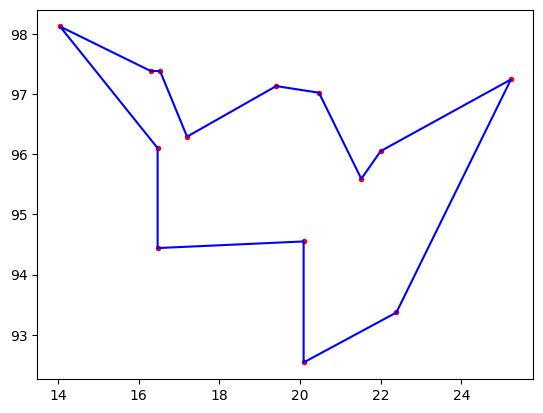

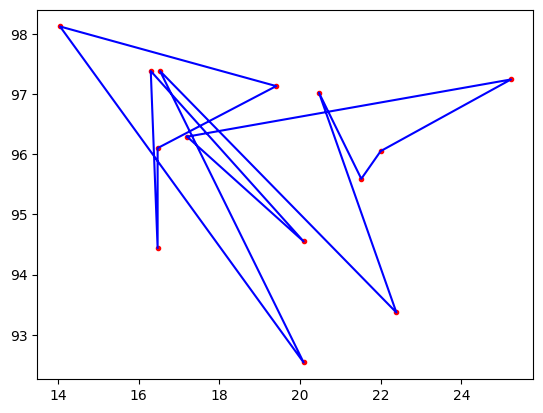

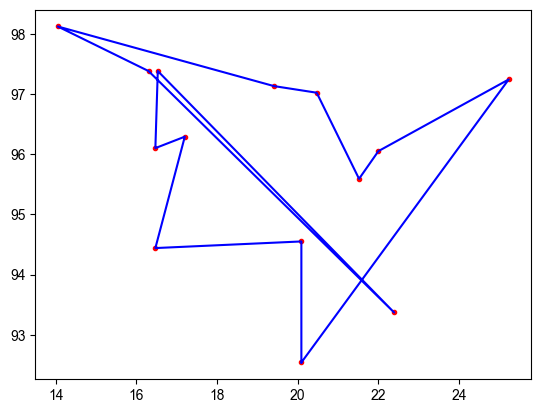

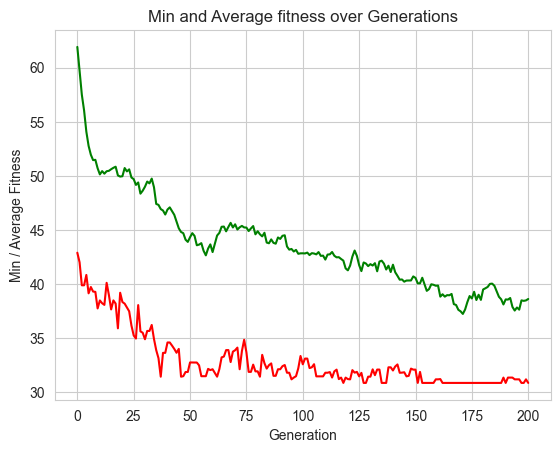

In [5]:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # Hall of Fame to store the best individual
    hof = tools.HallOfFame(1)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # Extract the best individual (solution)
    # best_solution = hof[0]
    # worst_solution = hof[-1]
    # Extract the best and worst individuals (solutions)
    best_solution = tools.selBest(population, 1)[0]
    worst_solution = tools.selWorst(population, 1)[0]
    
    
    # Call the plotData method with the best solution
    tsp.plotData(best_solution)
    plt.show()
    # Call the plotData method with the worst solution
    tsp.plotData(worst_solution)
    plt.show()
    # Call the plotData method with a random solution in the population
    tsp.plotData(population[2])
    
    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # show both plots:
    plt.show()


if __name__ == "__main__":
    main()
